In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.optimize import OptimizeWarning, curve_fit
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [2]:
def auto_annotate(ax, text, xy, xytext_options, ha_options, **kwargs):
    """
    Automatically annotate a point on a matplotlib axis.
    
    ax: The axis object to annotate.
    text: The text for annotation.
    xy: The point to annotate (x, y).
    xytext_options: List of tuples for text offset (x_offset, y_offset).
    ha_options: List of horizontal alignments ('left', 'right', 'center').
    **kwargs: Additional keyword arguments for ax.annotate.
    """
    best_score = np.inf
    best_params = {}

    for xytext in xytext_options:
        for ha in ha_options:
            try:
                # Temporarily add annotation to check overlap
                annot = ax.annotate(text, xy, xytext=xytext, ha=ha, **kwargs)
                extent = annot.get_window_extent(renderer=ax.figure.canvas.get_renderer())
                score = np.sum([extent.overlaps(other.get_window_extent()) for other in ax.texts if other != annot])

                # Choose parameters with least overlap
                if score < best_score:
                    best_score = score
                    best_params = {'xytext': xytext, 'ha': ha}

                # Remove temporary annotation
                annot.remove()
            except Exception as e:
                print(f"Error during annotation trial: {e}")

    # Apply best parameters found
    ax.annotate(text, xy, **best_params, **kwargs)

In [3]:
df_raw = pd.read_csv('./GDSC2_curve_data/GDSC2_7_conc_Dec16.csv')
gdsc_fitted = pd.read_excel('./GDSC2_dataset/GDSC2_fitted_dose_response_27Oct23.xlsx')

In [4]:
cell_meta = pd.read_csv('./GDSC2_dataset/meta_data/cell_meta.csv')
drug_meta = pd.read_csv('./GDSC2_dataset/meta_data/drug_meta.csv')

In [5]:
df_raw['CL_drug_conc']=  df_raw['CL'].astype(str) + '_' + df_raw['drug']
def GDSC_x_50_from_lnIC50(lnIC50, maxC):
    # Calculate x from lnIC50 using the provided equation
    x = (lnIC50 - np.log(maxC)) / np.log(np.sqrt(10)) + 7
    return x/7
df_raw['IC50_x'] = df_raw.apply(lambda row: GDSC_x_50_from_lnIC50(row['LN_IC50'], row['maxc']), axis=1)

In [6]:
gdsc_fitted['CL_drug_conc'] =  gdsc_fitted['COSMIC_ID'].astype(str) + '_' + gdsc_fitted['DRUG_ID'].astype(str) + '_' + gdsc_fitted['MAX_CONC'].astype(str)

In [7]:
df_raw = pd.merge(df_raw, gdsc_fitted[['CL_drug_conc']], on='CL_drug_conc', how='inner')
df_raw = df_raw[df_raw.dilution_pattern == 'half-log']
x_cols = [f'x_{i}' for i in range(7)]
y_cols = [f'y_{i}' for i in range(7)]
for i, col in enumerate(x_cols):
    df_raw[col] = (i + 1) / 7

In [8]:
result_df= df_raw[['CL_drug_conc'] + y_cols]
result_df['min_y'] = result_df[y_cols].min(axis=1)
result_df['max_y'] = result_df[y_cols].max(axis=1)
sub_df = result_df[(result_df.max_y > 0.5) & (result_df.min_y < 0.5)]
sub_df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_2392646/2830213167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['min_y'] = result_df[y_cols].min(axis=1)
/tmp/ipykernel_2392646/2830213167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['max_y'] = result_df[y_cols].max(axis=1)


In [9]:
def sigmoid_2para(x, p, s):
    return 1.0 / (1 + np.exp((x - p) / -s))

def sigmoid_4para(c, L, k, c_0, d):
    return 1.0 / (L + np.exp(-k * (c - c_0))) + d
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## IC50 for sigmoid 2 and 4

In [10]:
def calculate_ic50_4_sig(L, k, c_0, d):
    """
    Calculate the IC50 value for a 4-parameter sigmoid model.

    Parameters:
    L, k, c_0, d: Parameters of the sigmoid model

    Returns:
    IC50 value, or 1.5 if the result is NaN
    """
    try:
        ic50 = c_0 - (1 / k) * np.log((2 / (1 - 2 * d)) - L) 
        if np.isnan(ic50):
            return 1.5
        else:
            return ic50
    except:
        return 1.5
    
def calculate_ic50_2_sig(p, s):
    return p

In [11]:
x_values = df_raw[x_cols].values[0]

## Iterate over all the rows:

In [ ]:
for col in ['2_para_0', '2_para_1', 'rmse_2_para', '4_para_0', '4_para_1', '4_para_2', '4_para_3', 'rmse_4_para']:
    sub_df[col] = np.nan
    
for index, row in sub_df.iterrows():
    sigmoid_2_failed = False
    sigmoid_4_failed = False
    y_values = row[y_cols].values
    CL,drug_name,maxc = row.CL_drug_conc.split('_')
    # Fit the 2-parameter sigmoid model
    try:
        popt_2para, _ = curve_fit(sigmoid_2para, x_values, y_values, maxfev=10000)
        estimated_sigmoid_2_predictions = sigmoid_2para(x_values, *popt_2para)
        rmse_sigmoid_2_predictions = rmse(estimated_sigmoid_2_predictions, y_values)
        sub_df.at[index, '2_para_0'] = popt_2para[0]
        sub_df.at[index, '2_para_1'] = popt_2para[1]
        sub_df.at[index, 'rmse_2_para'] = rmse_sigmoid_2_predictions
    except RuntimeError as e:
        print(f"Failed to fit 2-parameter sigmoid for row {index} CL {CL}, drug {drug_name}: {e}")
        sigmoid_2_failed = True
    try:
    # Fit the 4-parameter sigmoid model
        popt_4para, _ = curve_fit(sigmoid_4para, x_values, y_values, maxfev=10000)
        estimated_sigmoid_4_predictions = sigmoid_4para(x_values, *popt_4para)
        rmse_sigmoid_4_predictions = rmse(estimated_sigmoid_4_predictions, y_values)
        sub_df.at[index, '4_para_0'] = popt_4para[0]
        sub_df.at[index, '4_para_1'] = popt_4para[1]
        sub_df.at[index, '4_para_2'] = popt_4para[2]
        sub_df.at[index, '4_para_3'] = popt_4para[3]
        sub_df.at[index, 'rmse_4_para'] = rmse_sigmoid_4_predictions
    except RuntimeError as e:
        print(f"Failed to fit 4-parameter sigmoid for row {index} CL {CL}, drug {drug_name}: {e}")
        sigmoid_4_failed = True
    if sigmoid_2_failed and sigmoid_4_failed:
        print(f"Skipping for row {index} CL {CL}, drug {drug_name} as both fittings failed")
        continue   

In [95]:
## Drop the rows with nan values
fitted_sub_df = sub_df.dropna()
fitted_sub_df.reset_index(drop=True, inplace=True)

In [13]:
df_raw[['CL_drug_conc', 'IC50_x', 'LN_IC50']]

,CL_drug_conc,IC50_x,LN_IC50
0,683667_1003_0.1,1.104069,-1.463887
1,683667_1003_0.1,1.104069,-1.463887
2,683667_1003_0.1,1.104069,-1.463887
3,683667_1003_0.1,1.104069,-1.463887
4,683667_1003_0.1,1.104069,-1.463887
...,...,...,...
20840,1674021_1060_2.5,0.942099,0.449665
20841,1674021_1080_0.01,1.195708,-3.027952
20842,1674021_1084_0.02,1.275288,-1.693464
20843,1674021_1191_0.02,0.861840,-5.025459


In [96]:
temp_df = df_raw[['CL_drug_conc', 'IC50_x', 'LN_IC50']]
temp_df.drop_duplicates(inplace=True)
temp_df.reset_index(drop=True, inplace=True)
fitted_sub_df = pd.merge(fitted_sub_df, temp_df, on='CL_drug_conc', how='inner')

/tmp/ipykernel_1278782/3793947445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)


### IC50 for two curves

In [108]:
fitted_sub_df['IC50_4_para'] = fitted_sub_df.apply(lambda row: calculate_ic50_4_sig(
    row['4_para_0'], row['4_para_1'], row['4_para_2'], row['4_para_3']), axis=1)

fitted_sub_df['IC50_2_para'] = fitted_sub_df['2_para_0'] 

/tmp/ipykernel_1278782/1739044942.py:12: RuntimeWarning: invalid value encountered in log
  ic50 = c_0 - (1 / k) * np.log((2 / (1 - 2 * d)) - L)


In [12]:
# fitted_sub_df.to_csv('./GDSC2_curve_data/Dec13_4_2_fitted.csv', index=False)
fitted_sub_df = pd.read_csv('./GDSC2_curve_data/Dec13_4_2_fitted.csv')

In [13]:
## Find the subdf with rows has nan values
problem_df = sub_df[sub_df.isna().any(axis=1)]
problem_df.reset_index(drop=True, inplace=True)

## Let's only keep fine fitted rows for replicates

In [14]:
# idx_min_rmse_4_para = fitted_sub_df.groupby('CL_drug_conc')['rmse_4_para'].idxmin()

# # Group by 'CL_drug_conc' and find the index of the minimum 'rmse_2_para' within each group
# idx_min_rmse_2_para = fitted_sub_df.groupby('CL_drug_conc')['rmse_2_para'].idxmin()

# # Combine the indices, ensuring there are no duplicates in case the minimum rmse row is the same for both
# unique_indices = pd.Index(idx_min_rmse_4_para).union(pd.Index(idx_min_rmse_2_para))

def get_min_rmse_row(group):
    # Find the row index with the minimum rmse_4_para
    idx_min_rmse_4_para = group['rmse_4_para'].idxmin()
    # Find the row index with the minimum rmse_2_para
    idx_min_rmse_2_para = group['rmse_2_para'].idxmin()
    
    # Compare the minimum RMSE values and return the index of the overall minimum
    if group.loc[idx_min_rmse_4_para, 'rmse_4_para'] < group.loc[idx_min_rmse_2_para, 'rmse_2_para']:
        return idx_min_rmse_4_para
    else:
        return idx_min_rmse_2_para

# Group the DataFrame by 'CL_drug_conc' and apply the function
min_rmse_indices = fitted_sub_df.groupby('CL_drug_conc').apply(get_min_rmse_row)


# Use the unique indices to filter the rows in 'fitted_sub_df'
deduplicated_sub_df = fitted_sub_df.loc[min_rmse_indices]
deduplicated_sub_df.reset_index(drop=True, inplace=True)

In [15]:
deduplicated_sub_df.sort_values(by=['rmse_4_para']).head(10)

,CL_drug_conc,y_0,y_1,y_2,y_3,y_4,y_5,y_6,min_y,max_y,...,rmse_2_para,4_para_0,4_para_1,4_para_2,4_para_3,rmse_4_para,IC50_x,LN_IC50,IC50_4_para,IC50_2_para
1678,906855_1191_0.02,0.0,0.0,0.0,0.0,0.005181,0.901890,0.925292,0.0,0.925292,...,0.028212,1.080736,61.816497,0.799329,-1.903606e-07,2.492469e-07,0.807816,-5.460842,0.800690,0.813840
945,713880_1003_0.1,0.0,0.0,0.0,0.0,0.006172,0.809806,0.859618,0.0,0.859618,...,0.052844,1.163274,54.020676,0.808332,-6.916499e-07,9.056539e-07,0.855996,-3.463120,0.811631,0.820925
1271,905939_1007_0.0125,0.0,0.0,0.0,0.0,0.015925,0.608392,0.642231,0.0,0.642231,...,0.097114,1.556935,45.915575,0.803893,-5.781613e-06,7.572118e-06,0.848557,-5.602511,0.821623,0.882501
1617,906833_1080_0.01,0.0,0.0,0.0,0.0,0.007138,0.445132,0.627874,0.0,0.627874,...,0.060315,1.589533,37.448718,0.845924,-8.561308e-06,1.121933e-05,0.946674,-5.034930,0.869704,0.922740
2121,908148_1003_0.1,0.0,0.0,0.0,0.0,0.017874,0.851970,0.935992,0.0,0.935992,...,0.023973,1.068173,43.771408,0.805776,-8.762384e-06,1.147701e-05,0.804437,-3.878637,0.807390,0.812961
3076,998184_1191_0.02,0.0,0.0,0.0,0.0,0.017174,0.846578,0.937712,0.0,0.937712,...,0.023311,1.066184,43.455519,0.807378,-8.800682e-06,1.152735e-05,0.811400,-5.431959,0.808954,0.813936
973,724825_1003_0.1,0.0,0.0,0.0,0.0,0.022430,0.709994,0.761997,0.0,0.761997,...,0.086323,1.312104,42.747794,0.802405,-1.286137e-05,1.684752e-05,0.849392,-3.516343,0.811158,0.824884
550,1330985_1080_0.01,0.0,0.0,0.0,0.0,0.010336,0.518288,0.705559,0.0,0.705559,...,0.065418,1.414502,36.539285,0.838975,-1.415958e-05,1.855852e-05,0.900831,-5.404374,0.853628,0.887907
2632,909776_1007_0.0125,0.0,0.0,0.0,0.0,0.013334,0.428496,0.566684,0.0,0.566684,...,0.062517,1.760070,33.934054,0.840760,-2.672012e-05,3.504196e-05,1.019405,-4.225639,0.882837,0.944241
1593,906830_1003_0.1,0.0,0.0,0.0,0.0,0.021121,0.455706,0.515995,0.0,0.515995,...,0.074590,1.936420,36.188183,0.819686,-3.124350e-05,4.096215e-05,0.917373,-2.968478,0.895883,0.956861


In [254]:
deduplicated_sub_df[deduplicated_sub_df['rmse_2_para'] < deduplicated_sub_df['rmse_4_para']].sort_values(by=['IC50_4_para'],ascending=False).head(10)

,CL_drug_conc,y_0,y_1,y_2,y_3,y_4,y_5,y_6,min_y,max_y,...,rmse_2_para,4_para_0,4_para_1,4_para_2,4_para_3,rmse_4_para,IC50_x,LN_IC50,IC50_4_para,IC50_2_para
1065,724872_1191_0.02,0.070574,0.102259,0.000000,0.000000,0.000000,0.817050,0.936920,0.0,0.936920,...,0.052653,-835.648951,-16.679874,34.841679,0.276454,0.383678,0.836773,-5.227474,35.245371,0.827646
2441,909713_1248_0.1,0.131676,0.000000,0.000000,0.000000,0.000000,0.534956,0.797672,0.0,0.797672,...,0.073543,-848.925227,-17.268916,32.687705,0.210364,0.300828,0.919131,-2.954310,33.078466,0.866269
333,1297447_1191_0.02,0.000000,0.000000,0.000000,0.000000,0.011532,0.769598,0.897164,0.0,0.897164,...,0.038302,-43.274979,-11.462234,30.702901,0.262864,0.377006,0.831081,-5.273347,31.039708,0.823230
1727,906871_1191_0.02,0.068018,0.043336,0.000000,0.095801,0.055677,0.741075,0.947896,0.0,0.947896,...,0.049757,-6.678756,-15.373132,30.692163,0.428557,0.362976,0.819692,-5.365133,30.889194,0.817008
2739,910706_1080_0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.969507,0.0,0.969507,...,0.011525,-17.045901,-16.388046,30.390909,0.197158,0.339257,0.932005,-5.153147,30.574761,0.913831
765,687568_1191_0.02,0.060860,0.000000,0.006866,0.056384,0.119424,0.646171,0.943326,0.0,0.943326,...,0.029136,-288.388943,-16.453489,29.531337,0.265326,0.348177,0.860771,-5.034078,29.876490,0.823615
3,1240121_1080_0.01,0.023495,0.000000,0.000000,0.000000,0.023495,0.683249,0.843184,0.0,0.843184,...,0.056131,-24.785229,-12.035349,29.537305,0.265122,0.343351,0.859716,-5.735724,29.817211,0.828607
1403,905974_1191_0.02,0.031815,0.186621,0.000000,0.000000,0.183347,0.772832,0.950659,0.0,0.950659,...,0.072622,-308.491538,-17.309364,28.940056,0.306849,0.363558,0.804150,-5.490384,29.272151,0.793509
2384,909696_1191_0.02,0.000000,0.066012,0.000000,0.004089,0.044148,0.069656,0.931358,0.0,0.931358,...,0.029968,-75.485712,-14.089753,28.013230,0.172570,0.316434,0.936802,-4.421340,28.322930,0.928297
2472,909720_1191_0.02,0.000000,0.000000,0.007387,0.000000,0.000000,0.079062,0.927180,0.0,0.927180,...,0.002800,-23.921953,-12.725340,27.817139,0.186607,0.320533,0.973150,-4.128410,28.076465,0.927301


In [16]:
def plot_sigmoid_curves(df, row_index):
    fig, ax = plt.subplots(dpi=200)
    sub_row = df.iloc[row_index]
    y_values = sub_row[y_cols].values
    GDSC_IC50 = sub_row['IC50_x']
    sigmoid_4_IC50 = sub_row['IC50_4_para']
    sigmoid_2_IC50 = sub_row['IC50_2_para']
    if sigmoid_2_IC50 > 1.5:
        sigmoid_2_IC50 = 1.5
    if sigmoid_4_IC50 > 1.5:
        sigmoid_4_IC50 = 1.5
    if sigmoid_2_IC50 < 0:
        sigmoid_2_IC50 = 0
    if sigmoid_4_IC50 < 0:
        sigmoid_4_IC50 = 0
    sigmoid_4_model_cols = ['4_para_0', '4_para_1', '4_para_2', '4_para_3']
    sigmoid_2_model_cols = ['2_para_0', '2_para_1']
    sigmoid_4_dict = {'rmse': sub_row['rmse_4_para'], 'model': sub_row[sigmoid_4_model_cols]}
    sigmoid_2_dict = {'rmse': sub_row['rmse_2_para'], 'model': sub_row[sigmoid_2_model_cols]}
    CL,drug_name,maxc = sub_row.CL_drug_conc.split('_')
    cell_name = cell_meta[cell_meta.COSMIC_ID == int(CL)].CELL_LINE_NAME.unique()[0]
    drug_identifier = drug_meta[drug_meta.DRUG_ID == int(drug_name)].DRUG_NAME.unique()[0]
    a, b = sigmoid_2_dict['model']
    # x_high = max(4*b + a, 1.1)
    # x_high = min(x_high, 1.5)
    # x_low = min(-4*b + a, 0)
    # x_low = max(x_low, -1.)
    x_high = 1.1
    x_low = -0.1
    ## use np linspace to generate 1000 points between x_low and x_high      
    x_dense = np.linspace(x_low, x_high, 1000)
    rmse_sigmoid_2_predictions = sigmoid_2_dict['rmse']
    predicted_sig_2para = sigmoid_2para(x_dense, a, b)
    pred_sig2_y = sigmoid_2para(x_values, a, b)
    pred_sig4_y = sigmoid_4para(x_values, *sigmoid_4_dict['model'])
    L_fit, k_fit, x0_fit, d_fit = sigmoid_4_dict['model']
    rmse_sigmoid_4_predictions = sigmoid_4_dict['rmse']
    predicted_sig_4para = sigmoid_4para(x_dense, L_fit, k_fit, x0_fit, d_fit)
    plt.plot(x_dense, predicted_sig_2para, label=f'Fitted Sigmoid 2-Parameter\nRMSE: {rmse_sigmoid_2_predictions:.3f}', color = '#3C5488FF')
    plt.plot(x_dense, predicted_sig_4para, label=f'Fitted Sigmoid 4-Parameter\nRMSE: {rmse_sigmoid_4_predictions:.3f}', color='#F39B7FFF')
    plt.scatter(x_values, y_values, color='black', marker='o', facecolors='none', edgecolors='black', label = 'Observation')
    plt.scatter(x_values, pred_sig2_y, marker='^', color='#3C5488FF', label='2_para prediction')
    plt.scatter(x_values, pred_sig4_y, marker='^', color='#F39B7FFF', label='4_para prediction')        
    plt.scatter(GDSC_IC50, [0.5], color='red', marker='s', s=40, alpha=0.6)  # 's' for square shape
    plt.axvline(GDSC_IC50, color='red', linestyle='dashed', linewidth= 1, label=f'GDSC IC50: {GDSC_IC50:.3f}')
    plt.axhline(0.5, color='red', linestyle='dashed', linewidth= 1)
    plt.scatter(sigmoid_2_IC50, [0.5], color='skyblue', marker='s', s=40, alpha=0.6)  # 's' for square shape
    plt.axvline(sigmoid_2_IC50, color='skyblue', linestyle='dashed', linewidth=1, label=f'2_para IC50: {sigmoid_2_IC50:.3f}')
    plt.scatter(sigmoid_4_IC50, [0.5], color='goldenrod', marker='s', s=40, alpha=0.6)  # 's' for square shape
    plt.axvline(sigmoid_4_IC50, color='goldenrod', linestyle='dashed', linewidth = 1, label=f'4_para IC50: {sigmoid_4_IC50:.3f}')
    plt.xlabel('Normalized concentration', fontsize=12)
    plt.ylabel('Normalized response', fontsize=12)
    # drug_name = drug.split('_')[0]
    # maxc = drug.split('_')[1]
    plt.title(f'Dose-response curves for drug {drug_name} on cell line {CL} with max concentration {maxc} µM')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    annotation_x = x_low + (x_high - x_low) * 0.1 # Adjust horizontal position
    annotation_y = 0.8
    plt.annotate(f"Cell-line: {cell_name}\n\nDrug: {drug_identifier}\n\nMax dose = {maxc} uM",
                    (annotation_x, annotation_y), ha='left', va='center', fontsize= 11, xycoords='axes fraction')

    plt.grid(False)
    return fig, ax

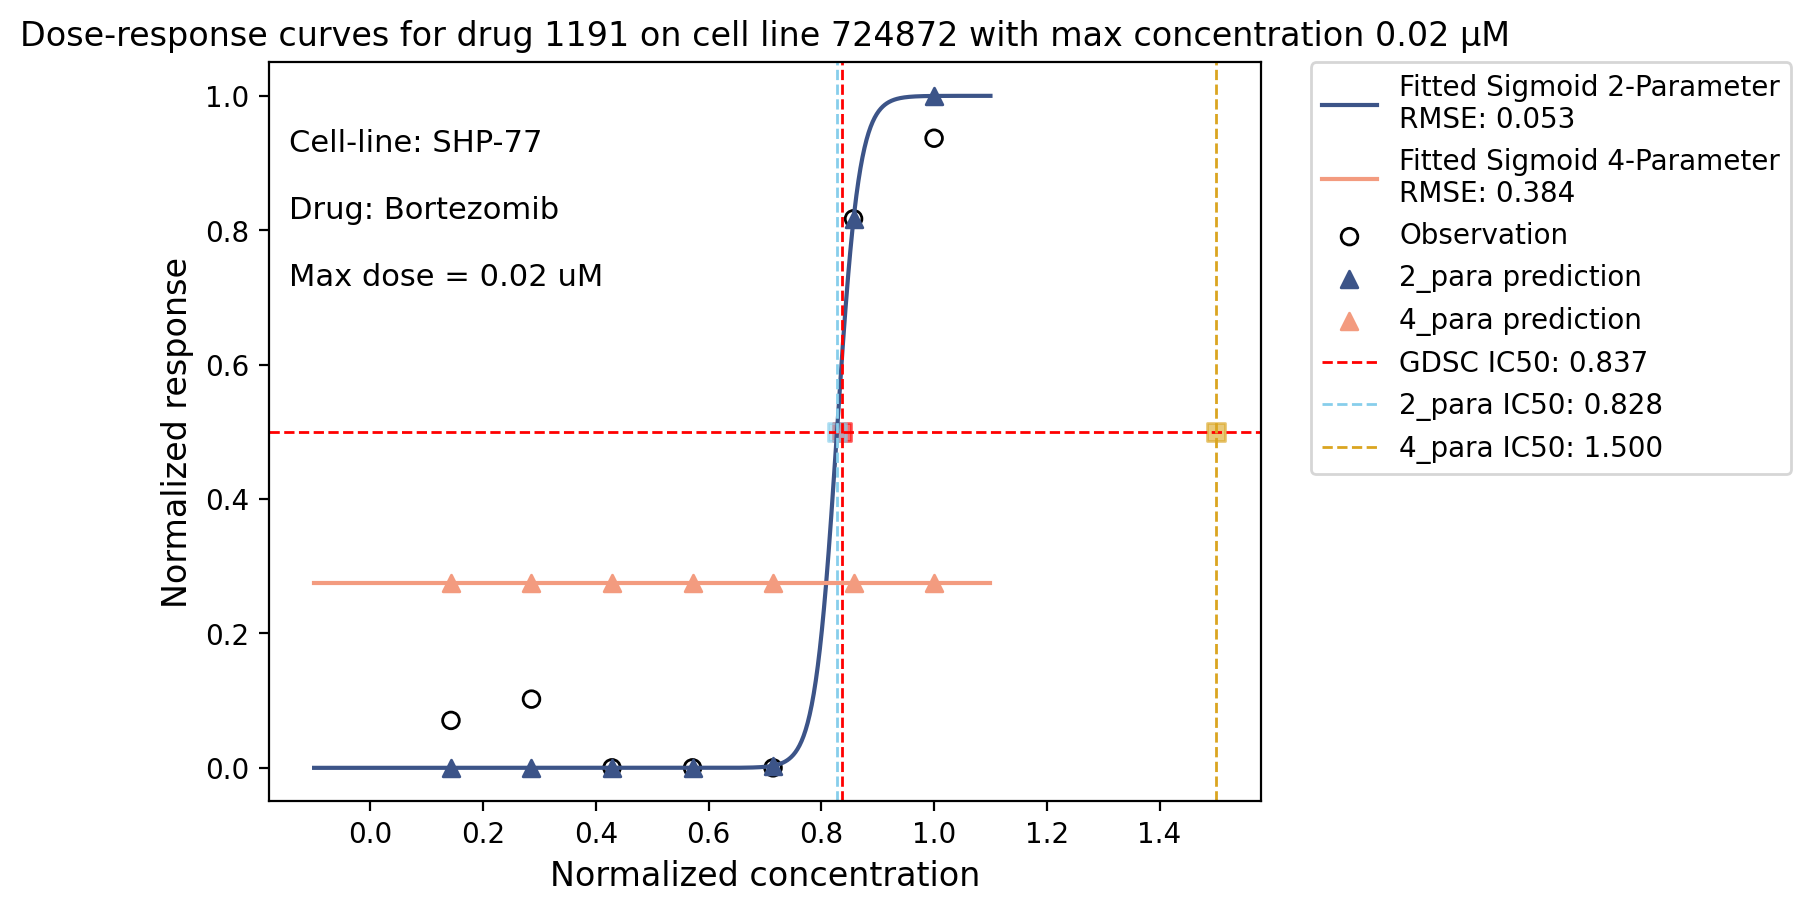

In [17]:
fig, ax = plot_sigmoid_curves(df = deduplicated_sub_df, row_index = 1065)

In [58]:
para_2_better_df = fitted_sub_df[fitted_sub_df['rmse_2_para'] < fitted_sub_df['rmse_4_para']]

In [190]:
para_2_better_df.sort_values(by='rmse_4_para', ascending=True).head(20)

,CL_drug_conc,y_0,y_1,y_2,y_3,y_4,y_5,y_6,min_y,max_y,2_para_0,2_para_1,rmse_2_para,4_para_0,4_para_1,4_para_2,4_para_3,rmse_4_para
7846,910689_1060_2.5,0.407575,0.354449,0.373403,0.574659,0.396210,0.437972,0.464554,0.354449,0.574659,1.343269,2.725374,0.063373,4.864875,-10.019131,5.645045,0.224277,0.068389
4511,906833_1003_0.1,0.094092,0.097586,0.132743,0.319156,0.536902,0.659914,0.871923,0.094092,0.871923,0.706613,0.177194,0.033873,-1.006380,0.000026,46.551935,193.177800,0.074112
7845,910689_1060_2.5,0.262590,0.406012,0.399185,0.412838,0.508476,0.457262,0.494824,0.262590,0.508476,0.923391,1.079524,0.040078,4.320482,-6.268064,7.073893,0.188714,0.075850
9973,1330942_1060_2.5,0.264527,0.389272,0.372247,0.428955,0.445920,0.536616,0.434590,0.264527,0.536616,0.978737,1.110287,0.045052,5.887820,-15.228359,10.222802,0.240462,0.076814
2738,905962_1060_2.5,0.348331,0.469612,0.451083,0.570930,0.546954,0.591502,0.533263,0.348331,0.591502,0.561627,1.105666,0.045374,11.874143,6.681440,-5.332169,0.417451,0.078390
10363,1503364_2048_0.1,0.165598,0.158772,0.258904,0.393166,0.711700,0.618421,0.704874,0.158772,0.711700,0.663617,0.280317,0.075365,-0.951222,0.001709,0.004318,-20.488452,0.080551
6586,908473_1060_2.5,0.253693,0.326002,0.390281,0.394275,0.462590,0.522833,0.350091,0.253693,0.522833,1.176876,1.291358,0.062590,5.519287,-12.194130,6.182062,0.204498,0.082001
9971,1330942_1060_2.5,0.299431,0.327208,0.354985,0.454936,0.499332,0.516010,0.332729,0.299431,0.516010,1.230951,1.584025,0.070628,-19.077371,8.492483,-6.023608,0.450223,0.083044
3645,906793_1060_2.5,0.395444,0.479531,0.627678,0.623656,0.635681,0.635681,0.599649,0.395444,0.635681,0.272762,1.010267,0.056605,4.007864,-4.345103,6.331818,0.321537,0.088123
2800,905962_1060_2.5,0.353325,0.389621,0.419292,0.481912,0.640170,0.488536,0.547878,0.353325,0.640170,0.672554,0.983719,0.056319,5.084609,-35.610011,10.192104,0.277719,0.091040


### Now we fit NN to the dataset.

In [53]:
fitted_sub_df['CL'] = fitted_sub_df.apply(lambda row: row.CL_drug_conc.split('_')[0], axis=1)
fitted_sub_df['drug'] = fitted_sub_df.apply(lambda row: row.CL_drug_conc.split('_')[1], axis=1)
fitted_sub_df['conc'] = fitted_sub_df.apply(lambda row: row.CL_drug_conc.split('_')[2], axis=1)
fitted_sub_df['IC_50_NN'] = np.nan
fitted_sub_df['rmse_nn'] = np.nan

In [19]:
x_train = torch.tensor(df_raw[x_cols].values[0], dtype=torch.float32).unsqueeze(1)
y_df = torch.tensor(fitted_sub_df[y_cols].values, dtype=torch.float32)
x_dense = np.linspace(-0.1, 1.1, 100000)
x_dense_tensor = torch.tensor(x_dense, dtype=torch.float32).unsqueeze(1)
x_train_gpu = x_train.cuda()
y_df_gpu = y_df.cuda()
x_dense_tensor_gpu = x_dense_tensor.cuda()

In [20]:
df_torch = fitted_sub_df[['CL_drug_conc', 'CL', 'drug', 'conc'] + y_cols]
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
net = Net()
net_cpu = Net()
net.cuda()
def train_NN_curve(row_idx):
    y_train = y_df_gpu[row_idx].unsqueeze(1)
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Training loop
    for epoch in range(1501):
        optimizer.zero_grad()
        output = net(x_train_gpu)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # if epoch % 500 == 0:
        #     print(f'Epoch {epoch}, Loss: {loss.item()}')
    # print(f'Saving model for row {row_idx}')
    rmse_nn = loss.item()
    torch.save(net.state_dict(), f'./fitting_curve/weight/NN_curve_{row_idx}.pth')
    y_dense_tensor = net(x_dense_tensor_gpu)
    difference = torch.abs(y_dense_tensor - 0.5)

    # Find the index of the minimum difference
    min_diff_idx = torch.argmin(difference)

    # Find the corresponding x value (ensure x_dense is a tensor or convert it to a tensor)
    IC50_NN = x_dense_tensor[min_diff_idx].item()
    return net, IC50_NN, rmse_nn

In [47]:
model = Net()
model.cuda()
model.load_state_dict(torch.load(f'./fitting_curve/weight/NN_curve_{2}.pth'))

<All keys matched successfully>

In [60]:
model = Net()
model.cuda()
for idx in range(len(fitted_sub_df)):
    model.load_state_dict(torch.load(f'./fitting_curve/weight/NN_curve_{idx}.pth'))
    # y_dense_tensor = model(x_dense_tensor)
    y_dense_tensor = model(x_dense_tensor_gpu)
    y_pred = model(x_train_gpu)
    rmse_nn = nn.MSELoss()(y_pred, y_df_gpu[idx].unsqueeze(1)).item()
    responses = y_dense_tensor.squeeze()

    # Find where responses are less than 0.5
    less_than_05 = responses < 0.5

    # Find the first index where the response crosses 0.5
    # We do this by looking for the first False (response >= 0.5) after a True (response < 0.5)
    crossing_indices = (less_than_05[:-1] & ~less_than_05[1:]).nonzero()

    if crossing_indices.nelement() != 0:
        # Get the first crossing index
        first_crossing_idx = crossing_indices[0, 0].item() + 1  # +1 because we want the first response >= 0.5

        # Find the corresponding x value
        IC50_NN = x_dense_tensor_gpu[first_crossing_idx].item()
    else:
        difference = torch.abs(y_dense_tensor - 0.5)
        min_diff_idx = torch.argmin(difference)
        IC50_NN = x_dense_tensor[min_diff_idx].item()
    fitted_sub_df.loc[idx, 'IC_50_NN'] = IC50_NN
    fitted_sub_df.loc[idx, 'rmse_nn'] = rmse_nn
    if idx % 1000 == 0:
        print(f'We have processed {idx} models')

We have processed 0 models
We have processed 1000 models
We have processed 2000 models
We have processed 3000 models
We have processed 4000 models
We have processed 5000 models
We have processed 6000 models
We have processed 7000 models
We have processed 8000 models
We have processed 9000 models
We have processed 10000 models


In [458]:
print('Start training')
for i in range(len(fitted_sub_df)):
    model, IC50_NN, rmse_nn = train_NN_curve(i)
    fitted_sub_df.loc[i, 'IC_50_NN'] = IC50_NN
    fitted_sub_df.loc[i, 'rmse_nn'] = rmse_nn
    if i % 1000 == 0:
        print(f'We have saved {i} models')
print('Finish training')

Start training
We have saved 0 models
We have saved 1000 models
We have saved 2000 models
We have saved 3000 models
We have saved 4000 models
We have saved 5000 models
We have saved 6000 models
We have saved 7000 models
We have saved 8000 models
We have saved 9000 models
We have saved 10000 models
Finish training


In [55]:
fitted_sub_df[['IC50_4_para', 'IC50_2_para', 'IC_50_NN', 'IC50_x']]

,IC50_4_para,IC50_2_para,IC_50_NN,IC50_x
0,0.640018,0.662099,0.640479,0.666162
1,0.711937,0.837427,0.712300,0.857007
2,1.500000,0.935352,0.969427,0.919964
3,1.500000,0.748889,0.757709,0.722520
4,5.792989,0.300642,0.342504,0.309172
...,...,...,...,...
10454,-3.205828,0.920194,0.949014,0.936791
10455,0.846837,0.913135,0.849245,0.936791
10456,0.973886,0.975706,0.966871,1.006522
10457,13.478734,0.844328,0.842465,0.861840


In [493]:
row_index = 1
sub_row = fitted_sub_df.iloc[row_index]
IC50_NN = sub_row['IC_50_NN']
IC50_rmse = sub_row['rmse_nn']
model_nn_para = torch.load(f'./fitting_curve/weight/NN_curve_{row_index}.pth')
model = Net()
model.load_state_dict(model_nn_para)
y_dense_tensor = model(x_dense_tensor)
ax.plot(x_dense, y_dense_tensor.detach().numpy(), label=f'Fitted Sigmoid 2-Parameter\nRMSE: {IC50_rmse:.3f}', color = '#00A087FF')

# Update the legend to include the new line
ax.legend()

# To display the updated figure
plt.show()

In [474]:
model(x_dense_tensor)

tensor([[-0.0939],
        [-0.0939],
        [-0.0939],
        ...,
        [ 0.6181],
        [ 0.6181],
        [ 0.6181]], grad_fn=<AddmmBackward0>)

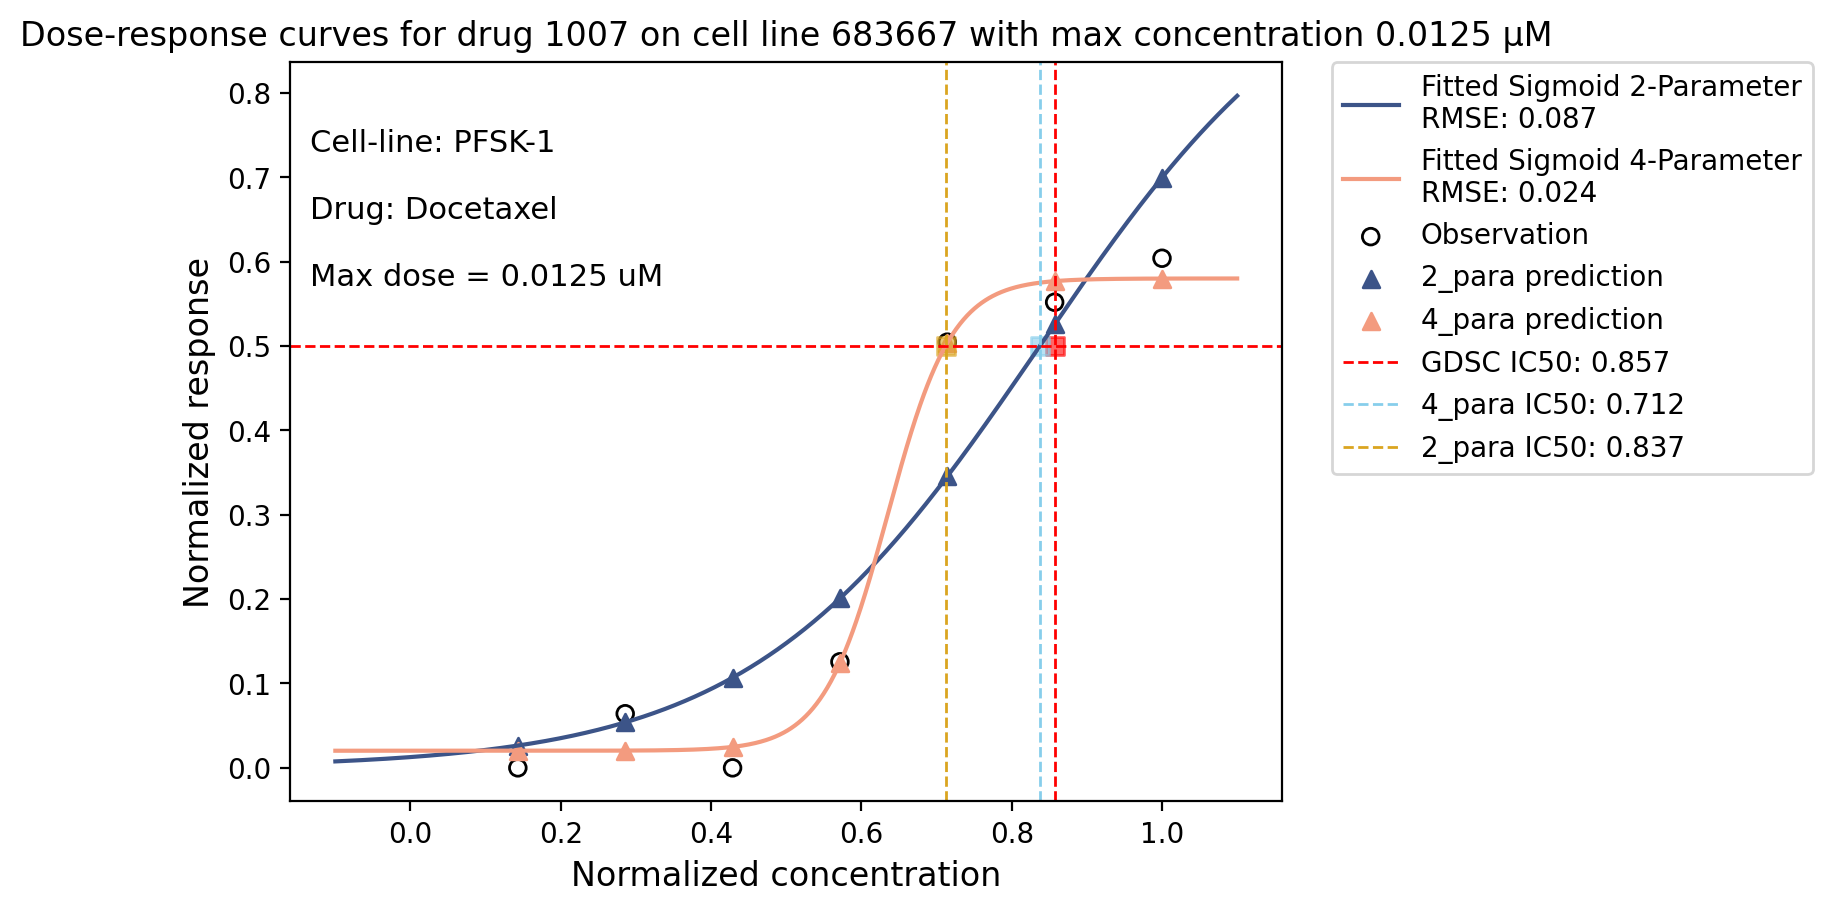

In [514]:
fig, ax = plot_curves(df = fitted_sub_df, row_index = 1)

In [57]:
def plot_all_curves(df, row_index):
    fig, ax = plt.subplots(dpi=200)
    sub_row = df.iloc[row_index]
    y_values = sub_row[y_cols].values
    GDSC_IC50 = sub_row['IC50_x']
    sigmoid_4_IC50 = sub_row['IC50_4_para']
    sigmoid_2_IC50 = sub_row['IC50_2_para']
    if sigmoid_2_IC50 > 1.5:
        sigmoid_2_IC50 = 1.5
    if sigmoid_4_IC50 > 1.5:
        sigmoid_4_IC50 = 1.5
    if sigmoid_2_IC50 < 0:
        sigmoid_2_IC50 = 0
    if sigmoid_4_IC50 < 0:
        sigmoid_4_IC50 = 0
    IC50_NN = sub_row['IC_50_NN']
    rmse_nn = sub_row['rmse_nn']
    model_nn_para = torch.load(f'./fitting_curve/weight/NN_curve_{row_index}.pth')
    model = Net()
    model.load_state_dict(model_nn_para)
    y_dense_tensor = model(x_dense_tensor)
    pred_nn = model(x_train)
    sigmoid_4_model_cols = ['4_para_0', '4_para_1', '4_para_2', '4_para_3']
    sigmoid_2_model_cols = ['2_para_0', '2_para_1']
    sigmoid_4_dict = {'rmse': sub_row['rmse_4_para'], 'model': sub_row[sigmoid_4_model_cols]}
    sigmoid_2_dict = {'rmse': sub_row['rmse_2_para'], 'model': sub_row[sigmoid_2_model_cols]}
    CL,drug_name,maxc = sub_row.CL_drug_conc.split('_')
    cell_name = cell_meta[cell_meta.COSMIC_ID == int(CL)].CELL_LINE_NAME.unique()[0]
    drug_identifier = drug_meta[drug_meta.DRUG_ID == int(drug_name)].DRUG_NAME.unique()[0]
    a, b = sigmoid_2_dict['model']
    # x_high = max(4*b + a, 1.1)
    # x_high = min(x_high, 1.5)
    # x_low = min(-4*b + a, 0)
    # x_low = max(x_low, -1.)
    x_high = 1.1
    x_low = -0.1
    ## use np linspace to generate 1000 points between x_low and x_high      
    x_dense = np.linspace(x_low, x_high, 1000)
    rmse_sigmoid_2_predictions = sigmoid_2_dict['rmse']
    predicted_sig_2para = sigmoid_2para(x_dense, a, b)
    pred_sig2_y = sigmoid_2para(x_values, a, b)
    pred_sig4_y = sigmoid_4para(x_values, *sigmoid_4_dict['model'])
    L_fit, k_fit, x0_fit, d_fit = sigmoid_4_dict['model']
    rmse_sigmoid_4_predictions = sigmoid_4_dict['rmse']
    predicted_sig_4para = sigmoid_4para(x_dense, L_fit, k_fit, x0_fit, d_fit)
    ## Curves
    plt.plot(x_dense, predicted_sig_2para, label=f'Fitted Sigmoid 2-Parameter\nRMSE: {rmse_sigmoid_2_predictions:.3f}', color = '#3C5488FF')
    plt.plot(x_dense, predicted_sig_4para, label=f'Fitted Sigmoid 4-Parameter\nRMSE: {rmse_sigmoid_4_predictions:.3f}', color='#F39B7FFF')
    plt.plot(x_dense_tensor, y_dense_tensor.detach().numpy(), label=f'Fitted Neural network\nRMSE: {rmse_nn:.3f}', color = '#00A087FF')
    ## Scatter
    plt.scatter(x_values, y_values, color='black', marker='o', facecolors='none', edgecolors='black', label = 'Observation')
    plt.scatter(x_values, pred_sig2_y, marker='^', color='#3C5488FF', label='2_para prediction')
    plt.scatter(x_values, pred_sig4_y, marker='^', color='#F39B7FFF', label='4_para prediction') 
    plt.scatter(x_values, pred_nn.detach().numpy(), marker='^', color='#00A087FF', label='NN prediction')  
    ## GDSC IC50    
    plt.scatter(GDSC_IC50, [0.5], color='red', marker='s', s=40, alpha=0.6)  # 's' for square shape
    plt.axvline(GDSC_IC50, color='red', linestyle='dashed', linewidth= 1, label=f'GDSC IC50: {GDSC_IC50:.3f}')
    plt.axhline(0.5, color='black', linestyle='dashed', linewidth= 1, label = 'Response at 0.5')
    ## 2 para
    plt.scatter(sigmoid_2_IC50, [0.5], color='skyblue', marker='s', s=40, alpha=0.6)  # 's' for square shape
    plt.axvline(sigmoid_2_IC50, color='skyblue', linestyle='dashed', linewidth=1, label=f'2_para IC50: {sigmoid_2_IC50:.3f}')
    ## 4 para
    plt.scatter(sigmoid_4_IC50, [0.5], color='goldenrod', marker='s', s=40, alpha=0.6)  # 's' for square shape
    plt.axvline(sigmoid_4_IC50, color='goldenrod', linestyle='dashed', linewidth = 1, label=f'4_para IC50: {sigmoid_4_IC50:.3f}')
    ## NN for IC50   
    plt.scatter(IC50_NN, [0.5], color='teal', marker='s', s=40, alpha=0.6)  # 's' for square shape
    plt.axvline(IC50_NN, color='teal', linestyle='dashed', linewidth=1, label=f'NN IC50: {IC50_NN:.3f}')    
    
    plt.xlabel('Normalized concentration', fontsize=12)
    plt.ylabel('Normalized response', fontsize=12)
    # drug_name = drug.split('_')[0]
    # maxc = drug.split('_')[1]
    plt.title(f'Dose-response curves for drug {drug_name} on cell line {CL} with max concentration {maxc} µM')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    annotation_x = x_low + (x_high - x_low) * 0.1 # Adjust horizontal position
    annotation_y = 0.8
    plt.annotate(f"Cell-line: {cell_name}\n\nDrug: {drug_identifier}\n\nMax dose = {maxc} uM",
                    (annotation_x, annotation_y), ha='left', va='center', fontsize= 11, xycoords='axes fraction')

    plt.grid(False)
    return fig, ax

(<Figure size 1280x960 with 1 Axes>,
 <Axes: title={'center': 'Dose-response curves for drug 2048 on cell line 683667 with max concentration 0.1 µM'}, xlabel='Normalized concentration', ylabel='Normalized response'>)

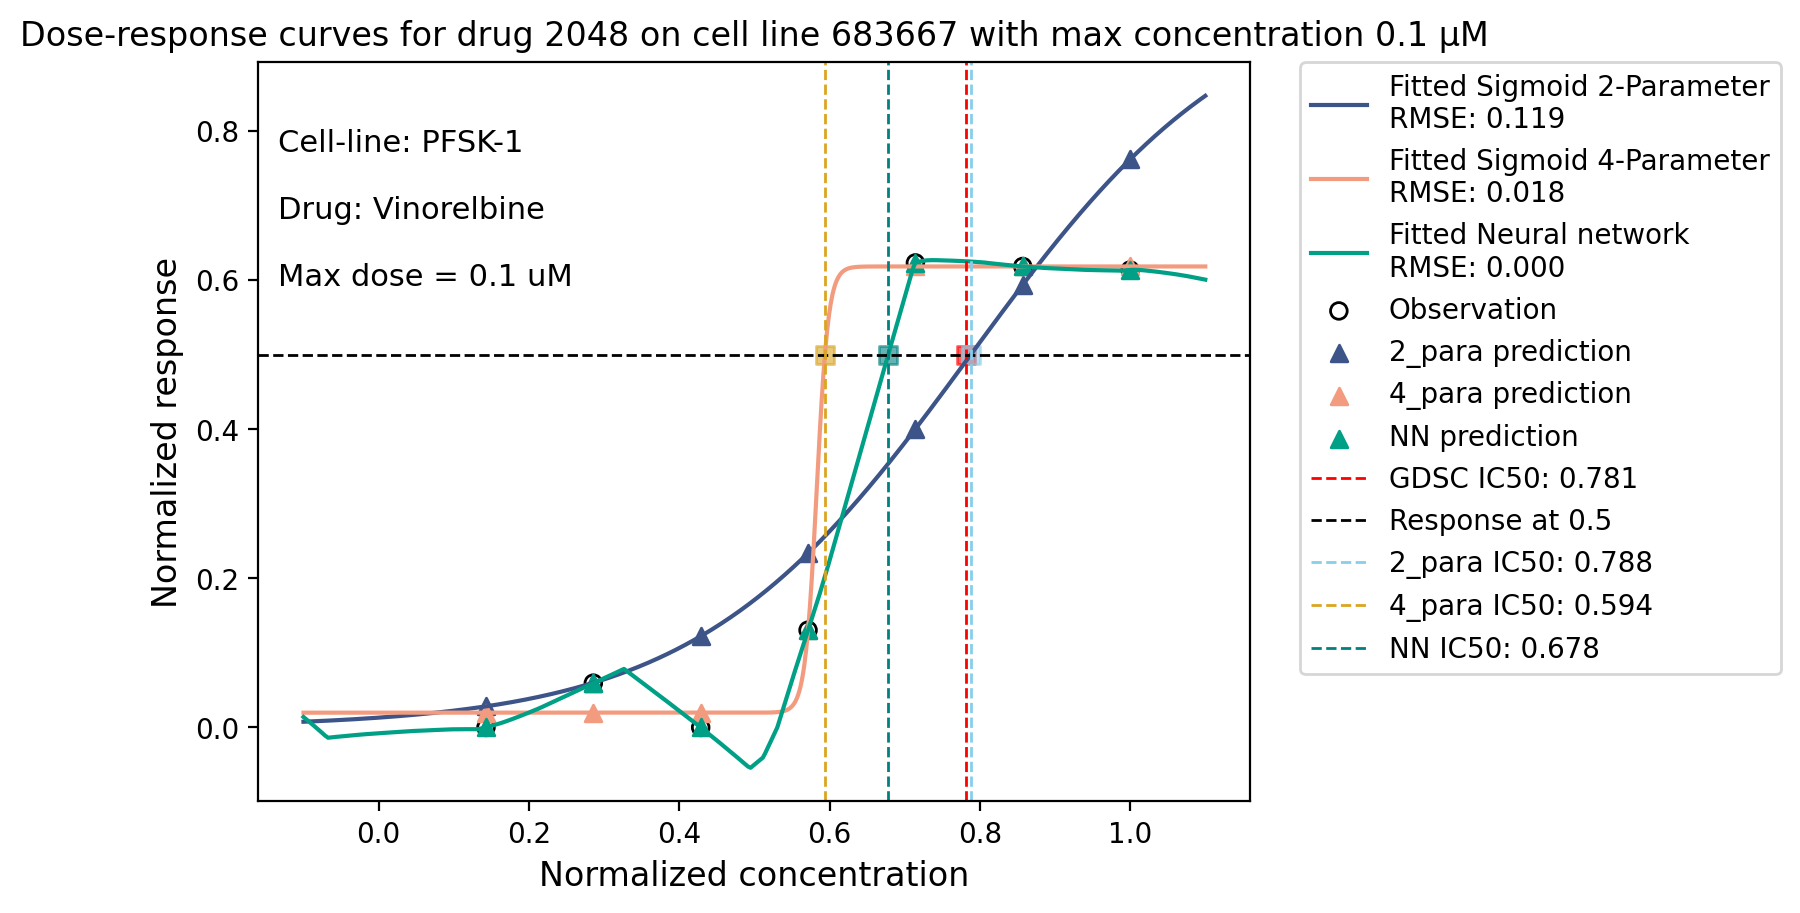

In [58]:
plot_all_curves(df = fitted_sub_df, row_index = 5)